# 0 Library Import

In [1]:
# Import libraries
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from scipy.stats import norm

# 1. Usual factors

## 1.1 Factor Data Import

Loading the dataset of individual factor returns on daily level

In [2]:
factor_ret_m = pd.read_csv('data/Fama_French_monthly_data_5_factors.csv', index_col=0)
factor_ret_m.index = pd.to_datetime(factor_ret_m.index)

## 1.2 Explanation of Factors

1. **Market (from Fama and French, 2015):**\
This represents the excess return of the market over the risk-free rate (Market Return - Risk-Free Rate). It is the foundational factor in asset pricing, capturing the equity market premium. Investors demand a risk premium for bearing systematic (market) risk. Stocks with higher sensitivity to market fluctuations (high beta) earn higher expected returns over time to compensate investors for exposure to market volatility.

3. **SMB (Small Minus Big, from Fama and French, 2015):**\
This factor captures the size effect. It is the return spread between small-cap and large-cap stocks, reflecting the tendency of smaller firms to outperform larger firms over time. Small-cap firms tend to be riskier than large-cap firms due to less diversification, limited resources, and higher vulnerability to economic downturns. Investors demand higher returns for holding these riskier stocks.

4. **HML (High Minus Low, from Fama and French, 2015):**\
This factor represents the value effect. It measures the return spread between high book-to-market (value) stocks and low book-to-market (growth) stocks, reflecting the tendency for value stocks to outperform growth stocks. Value stocks (high book-to-market) are often companies in distress or undergoing restructuring, leading to higher perceived risk. Investors require a risk premium to hold these stocks.

5. **RMW (Robust Minus Weak, from Fama and French, 2015):**\
Profitability factor introduced in their five-factor model. It captures the return spread between firms with robust profitability and firms with weak profitability, showing the tendency of more profitable firms to generate higher returns. Firms with robust profitability (higher earnings relative to assets) have better cash flows and are less likely to face financial distress. This makes them less risky, but empirically, they still earn higher returns.

6. **CMA (Conservative Minus Aggressive, from Fama and French, 2015):**\
Investment factor also introduced in the five-factor model. It measures the return spread between firms with conservative investment strategies and those with aggressive investment strategies, capturing the tendency for firms that invest conservatively to outperform. Firms with aggressive investment policies (e.g., high growth) often take on excessive risk, which does not always translate to higher profitability. Conservative firms, with steady investment, are less risky and more efficient with capital.

# 2. Vol-managed factors

## 2.1 Downloading dailty factor data and calculating monthly realized variance (RV) for each factor

In [3]:
def standardize_to_mean_one(s):
    # positive series -> scale so mean == 1
    return s / s.mean()

In [4]:
# Extracting tickers from the Symbol column
factor_ret_d = pd.read_csv('data/Fama_French_daily_data_5_factors.csv', index_col=0)
factor_ret_d.index = pd.to_datetime(factor_ret_d.index, format='%Y-%m-%d')     

 
$
\widehat{\sigma}^2_{t} \;=\; \sum_{d \in t} r_{d}^{\,2}.
$

In [5]:
### Getting the daily volatilites we are missing using the daily returns
RV = pd.DataFrame(index=factor_ret_m.index, columns=factor_ret_m.columns)

# find for each date in monthly observations all days that have the same month and year. Then find std
for factor in factor_ret_m.columns:
    for date in factor_ret_m.index:
        RV.loc[date, factor] = (factor_ret_d.loc[(factor_ret_d.index.month == date.month) & (factor_ret_d.index.year == date.year), factor]**2).resample('M').sum().values[0]

## 2.2 Calculating unscaled vol-managed factor performance

Unscaled volatility-managed return (uses information known at t-1)

$\tilde f^{\sigma}_{t} \;=\; \frac{1}{\widehat{\sigma}^2_{t-1}} \, f_{t}$

In [6]:
unscaled_vol_managed_factor = factor_ret_m/RV.shift(1)

In [7]:
unscaled_vol_managed_factor

,MKT,SMB,HML,RMW,CMA
1963-07-31,NaN,NaN,NaN,NaN,NaN
1963-08-31,-1.700391,-26.779737,-15.490944,27.13421,-10.771509
1963-09-30,7.800047,9.56807,7.325241,-3.539823,34.979424
1963-10-31,21.285653,-19.707207,34.727045,-10.411244,-42.30274
1963-11-30,-4.309519,15.074212,8.365534,-13.673939,7.249379
...,...,...,...,...,...
2024-08-31,-9.123984,-3.212319,-2.987351,15.948963,-12.81682
2024-09-30,-6.376184,-5.444339,13.472283,11.809041,-11.863083
2024-10-31,-6.077923,-6.992044,-0.204107,24.03698,-20.318682
2024-11-30,4.218016,3.706598,-11.61985,-10.371139,5.69395


## 2.3 Calculating c out-of-sample

Out-of-sample volatility-matching scale on a rolling window of length T

$
c_{t} \;=\;
\frac{\operatorname{Std}\!\left( f_{t-T:\,t-1} \right)}
     {\operatorname{Std}\!\left( \tilde f^{\sigma}_{t-T:\,t-1} \right)}.
$

In [8]:
T = 120

std_normal_factor = factor_ret_m.rolling(120).std()
# use rolling window to keep oos
std_vol_managed_unscaled_factor = unscaled_vol_managed_factor.rolling(120).std()
# to keep out-of-sample also need to shift c by 1 month
c_vol = (std_normal_factor / std_vol_managed_unscaled_factor).shift(1)

## 2.4 Find final vol-managed return

$f^{\sigma}_{t} \;=\; c_{t} \, \tilde f^{\sigma}_{t}.$

In [9]:
factor_ret_vol_managed_m = unscaled_vol_managed_factor * c_vol

# 3. Sentiment-managed factors via EPU

## 3.1 Download the data on EPU

In [10]:
epu = pd.read_csv('data/US_Policy_Uncertainty_Data.csv')
epu.index = pd.to_datetime(epu.Date)
epu = epu.drop(columns = ['Date'])
epu.index = epu.index + pd.DateOffset(days = -1)
epu = epu.sort_index()

truncating dates

In [11]:
epu = epu.loc[sorted(factor_ret_m.index)[0]:sorted(factor_ret_m.index)[-1],:]

## 3.2 Calculating unscaled EPU-managed factor performance

$\tilde f^{\sigma}_{t} \;=\; \frac{1}{EPU^2_{t-1}} \, f_{t}$

In [12]:
unscaled_epu_managed_factor = factor_ret_m.div(epu.iloc[:,0].shift(1),axis =0)

## 3.3 Calculating c out-of-sample


$
c_{t} \;=\;
\frac{\operatorname{Std}\!\left( f_{t-T:\,t-1} \right)}
     {\operatorname{Std}\!\left( \tilde f^{EPU}_{t-T:\,t-1} \right)}.
$

In [13]:
T = 120

std_normal_factor = factor_ret_m.rolling(120).std()
# use rolling window to keep oos
std_epu_managed_unscaled_factor = unscaled_epu_managed_factor.rolling(120).std()
# to keep out-of-sample also need to shift c by 1 month
c_epu = (std_normal_factor / std_epu_managed_unscaled_factor).shift(1)

## 3.4 Find epu-managed factor return

In [14]:
factor_ret_epu_managed_m = unscaled_epu_managed_factor * c_epu

# 4. Analysis

### 4.1 Trim all factors so that the comparison windows are same

In [15]:
# starting date
assert factor_ret_epu_managed_m.dropna().index[0] == factor_ret_vol_managed_m.dropna().index[0]
starting_date = factor_ret_epu_managed_m.dropna().index[0]

# ending date
assert factor_ret_epu_managed_m.dropna().index[-1] == factor_ret_vol_managed_m.dropna().index[-1] == factor_ret_m.index[-1] 

In [16]:
factor_ret_epu_managed_m = factor_ret_epu_managed_m.loc[starting_date:,:]
factor_ret_vol_managed_m = factor_ret_vol_managed_m.loc[starting_date:,:]
factor_ret_m = factor_ret_m.loc[starting_date:,:]

### 4.2 functions for SR calculation and Ledoit-Wolf Z-test with bootstrap

In [17]:
import numpy as np
import pandas as pd
from scipy.stats import norm

# ---------- Core utilities ----------
def sharpe_ratio(r, freq=12, rf=None):
    """
    Annualized Sharpe ratio for Series/DataFrame r (per-period returns).
    If rf is provided (scalar or Series), SR is computed on (r - rf).
    """
    r = pd.DataFrame(r).copy()
    if rf is not None:
        rf_ = rf if isinstance(rf, pd.Series) else pd.Series(rf, index=r.index)
        r = r.sub(rf_, axis=0)
    mu = r.mean()
    sd = r.std(ddof=1)
    return np.sqrt(freq) * mu / sd


def ledoit_wolf_sr_test(r1, r2, freq=12, rf=None, n_boot=4000, block_len=6, seed=123):
    """
    Ledoit–Wolf asymptotic Z-test + block-bootstrap p-value for SR difference.
    Returns dict with SR1, SR2, diff, z_asym, p_asym, p_boot.
    """
    df = pd.concat([pd.Series(r1), pd.Series(r2)], axis=1).dropna()
    df.columns = ['r1', 'r2']
    if rf is not None:
        rf_ = rf if isinstance(rf, pd.Series) else pd.Series(rf, index=df.index)
        rf_ = rf_.reindex(df.index).fillna(method='ffill')
        df = df.sub(rf_, axis=0)

    T = len(df)
    if T < 24:
        raise ValueError("Not enough observations for a reliable SR test.")

    # Annualized SRs
    SR1 = np.sqrt(freq) * df['r1'].mean() / df['r1'].std(ddof=1)
    SR2 = np.sqrt(freq) * df['r2'].mean() / df['r2'].std(ddof=1)
    diff = SR2 - SR1  # NOTE: second minus first (matches table convention)

    # Ledoit–Wolf asymptotic variance of SR2 − SR1
    rho = df['r1'].corr(df['r2'])
    var_diff = (1.0 / T) * (2 - 2 * rho + 0.5 * (SR2**2 + SR1**2 - 2 * SR2 * SR1 * rho**2))
    z = diff / np.sqrt(var_diff)
    p_asym = 2 * (1 - norm.cdf(abs(z)))

    # Block bootstrap (circular) for finite-sample robustness
    rng = np.random.default_rng(seed)
    L = int(block_len)
    B = int(n_boot)
    n_blocks = int(np.ceil(T / L))
    vals = df[['r1', 'r2']].to_numpy()
    diffs = np.empty(B)

    for b in range(B):
        starts = rng.integers(0, T, size=n_blocks)
        idx = np.concatenate([np.arange(s, s+L) % T for s in starts])[:T]
        r1b, r2b = vals[idx, 0], vals[idx, 1]
        SR1b = np.sqrt(freq) * r1b.mean() / r1b.std(ddof=1)
        SR2b = np.sqrt(freq) * r2b.mean() / r2b.std(ddof=1)
        diffs[b] = SR2b - SR1b

    # two-sided bootstrap p-value
    centered = diffs - diffs.mean()
    p_boot = (np.abs(centered) >= np.abs(diff - diffs.mean())).mean()

    return {'SR1': SR1, 'SR2': SR2, 'diff': diff, 'z_asym': z, 'p_asym': p_asym, 'p_boot': p_boot}


# ---------- Build the requested table ----------
def build_sr_diff_table(ret_orig, ret_vol, ret_epu,
                        freq=12, rf=None,
                        n_boot=4000, block_len=6, seed=123):
    """
    Columns = factors. Rows:
      SR: Original
      SR: Vol-Managed
      SR: EPU-Managed
      ΔSR (Vol − Original)
      p (Vol vs Orig)
      ΔSR (EPU − Original)
      p (EPU vs Orig)
      ΔSR (EPU − Vol)
      p (EPU vs Vol)
    """
    idx = ret_orig.index.intersection(ret_vol.index).intersection(ret_epu.index)
    cols = ret_orig.columns.intersection(ret_vol.columns).intersection(ret_epu.columns)

    R0 = ret_orig.loc[idx, cols].astype(float)
    Rv = ret_vol.loc[idx, cols].astype(float)
    Re = ret_epu.loc[idx, cols].astype(float)

    row_names = [
        'SR: Original',
        'SR: Vol-Managed',
        'SR: EPU-Managed',
        'ΔSR (Vol − Original)',
        'p (Vol vs Orig)',
        'ΔSR (EPU − Original)',
        'p (EPU vs Orig)',
        'ΔSR (EPU − Vol)',
        'p (EPU vs Vol)',
    ]
    out = pd.DataFrame(index=row_names, columns=cols, dtype=float)

    for f in cols:
        df = pd.concat([R0[f], Rv[f], Re[f]], axis=1).dropna()
        df.columns = ['orig', 'vol', 'epu']

        SR0 = sharpe_ratio(df['orig'], freq=freq, rf=rf).item()
        SRv = sharpe_ratio(df['vol'],  freq=freq, rf=rf).item()
        SRe = sharpe_ratio(df['epu'],  freq=freq, rf=rf).item()

        t_v0 = ledoit_wolf_sr_test(df['orig'], df['vol'], freq=freq, rf=rf,
                                   n_boot=n_boot, block_len=block_len, seed=seed)
        t_e0 = ledoit_wolf_sr_test(df['orig'], df['epu'], freq=freq, rf=rf,
                                   n_boot=n_boot, block_len=block_len, seed=seed+1)
        t_ev = ledoit_wolf_sr_test(df['vol'],  df['epu'], freq=freq, rf=rf,
                                   n_boot=n_boot, block_len=block_len, seed=seed+2)

        out.loc['SR: Original',           f] = SR0
        out.loc['SR: Vol-Managed',        f] = SRv
        out.loc['SR: EPU-Managed',        f] = SRe
        out.loc['ΔSR (Vol − Original)',   f] = t_v0['diff']
        out.loc['p (Vol vs Orig)',        f] = t_v0['p_boot']
        out.loc['ΔSR (EPU − Original)',   f] = t_e0['diff']
        out.loc['p (EPU vs Orig)',        f] = t_e0['p_boot']
        out.loc['ΔSR (EPU − Vol)',        f] = t_ev['diff']
        out.loc['p (EPU vs Vol)',         f] = t_ev['p_boot']

    return out



In [18]:
# Assuming you already have:
# factor_ret_m                 # original factors (monthly)
# factor_ret_vol_managed_m     # vol-managed (monthly)
# factor_ret_epu_managed_m     # EPU-managed (monthly)

tbl = build_sr_diff_table(
    ret_orig=factor_ret_m,
    ret_vol=factor_ret_vol_managed_m,
    ret_epu=factor_ret_epu_managed_m,
    freq=12,            # monthly → annualize by sqrt(12)
    rf=None,            # factors are already excess; pass a Series if needed
    n_boot=10000,        # tune up if you want tighter bootstrap p-values
    block_len=6,        # 6-month blocks for bootstrapping
    seed=2025
)

In [19]:
tbl.round(3)

,MKT,SMB,HML,RMW,CMA
SR: Original,0.397,-0.256,0.259,0.178,0.242
SR: Vol-Managed,0.513,-0.225,0.393,0.306,0.127
SR: EPU-Managed,0.515,-0.236,0.307,0.236,0.197
ΔSR (Vol − Original),0.116,0.031,0.134,0.127,-0.115
p (Vol vs Orig),0.969,0.977,0.965,0.980,0.977
ΔSR (EPU − Original),0.118,0.020,0.049,0.057,-0.045
p (EPU vs Orig),0.940,0.982,0.998,0.950,0.974
ΔSR (EPU − Vol),0.002,-0.011,-0.085,-0.070,0.070
p (EPU vs Vol),0.992,0.982,0.970,0.950,0.965


In [20]:
# (optional) export LaTeX straight away
latex_table = tbl.to_latex(float_format="%.3f")
print(latex_table)

\begin{tabular}{lrrrrr}
\toprule
 & MKT & SMB & HML & RMW & CMA \\
\midrule
SR: Original & 0.397 & -0.256 & 0.259 & 0.178 & 0.242 \\
SR: Vol-Managed & 0.513 & -0.225 & 0.393 & 0.306 & 0.127 \\
SR: EPU-Managed & 0.515 & -0.236 & 0.307 & 0.236 & 0.197 \\
ΔSR (Vol − Original) & 0.116 & 0.031 & 0.134 & 0.127 & -0.115 \\
p (Vol vs Orig) & 0.969 & 0.977 & 0.965 & 0.980 & 0.977 \\
ΔSR (EPU − Original) & 0.118 & 0.020 & 0.049 & 0.057 & -0.045 \\
p (EPU vs Orig) & 0.940 & 0.982 & 0.998 & 0.950 & 0.974 \\
ΔSR (EPU − Vol) & 0.002 & -0.011 & -0.085 & -0.070 & 0.070 \\
p (EPU vs Vol) & 0.992 & 0.982 & 0.970 & 0.950 & 0.965 \\
\bottomrule
\end{tabular}



### 4.3 functions for alphas

In [21]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

def _coerce_numeric(df: pd.DataFrame) -> pd.DataFrame:
    """Force all columns to float; drop rows that cannot be coerced."""
    for c in df.columns:
        df[c] = pd.to_numeric(df[c], errors='coerce')
    return df.dropna(how='any')

def alpha_regression(dep: pd.Series,
                     base: pd.Series,
                     controls: pd.DataFrame = None,
                     lags: int = 6):
    """
    Managed factor (dep) on unmanaged base (+ optional controls).
    Returns α, p(α), R², RMSE, N with HAC (NW) standard errors.
    """
    # Align on common dates and build design matrix
    parts = {'y': dep, 'base': base}
    df = pd.concat(parts, axis=1, join='inner')

    if controls is not None and len(controls.columns) > 0:
        # keep only controls that exist on the same dates
        ctrl = controls.reindex(df.index)
        df = pd.concat([df, ctrl], axis=1)

    # Coerce strictly numeric
    df = _coerce_numeric(df)

    y = df['y']
    X = df.drop(columns='y')
    X = sm.add_constant(X)

    # Safety check (helps diagnose if something still off)
    assert np.issubdtype(y.dtype, np.number), f"y dtype is {y.dtype}"
    assert all(np.issubdtype(X[c].dtype, np.number) for c in X.columns), \
        f"Non-numeric exog dtypes: {X.dtypes}"

    mod = sm.OLS(y, X, missing='drop').fit(
        cov_type='HAC', cov_kwds={'maxlags': int(lags)}
    )
    return {
        'alpha': float(mod.params['const']),
        'p_alpha': float(mod.pvalues['const']),
        'R2': float(mod.rsquared),
        'RMSE': float(np.sqrt(mod.scale)),
        'N': int(mod.nobs)
    }

def build_alpha_table(ret_orig: pd.DataFrame,
                      ret_vol: pd.DataFrame,
                      ret_epu: pd.DataFrame,
                      lags: int = 6,
                      controls: str = None):
    """
    Columns = factors common to all three frames.
    Rows report α / p / R² / RMSE / N for:
      - Vol-managed vs Original
      - EPU-managed vs Original
    controls: None | 'others'
    """
    # Ensure column names are strings (avoids weird object-columns later)
    ret_orig = ret_orig.copy(); ret_orig.columns = ret_orig.columns.astype(str)
    ret_vol  = ret_vol.copy();  ret_vol.columns  = ret_vol.columns.astype(str)
    ret_epu  = ret_epu.copy();  ret_epu.columns  = ret_epu.columns.astype(str)

    # intersect columns
    factors = sorted(set(ret_orig.columns) & set(ret_vol.columns) & set(ret_epu.columns))

    rows = [
        'α (Vol vs Orig)', 'p (Vol vs Orig)', 'R² (Vol vs Orig)',
        'RMSE (Vol vs Orig)', 'N (Vol vs Orig)',
        'α (EPU vs Orig)', 'p (EPU vs Orig)', 'R² (EPU vs Orig)',
        'RMSE (EPU vs Orig)', 'N (EPU vs Orig)'
    ]
    table = pd.DataFrame(index=rows, columns=factors, dtype=float)

    for f in factors:
        ctrls = None
        if controls == 'others':
            ctrls = ret_orig.drop(columns=f)

        res_v = alpha_regression(
            dep=ret_vol[f], base=ret_orig[f], controls=ctrls, lags=lags
        )
        res_e = alpha_regression(
            dep=ret_epu[f], base=ret_orig[f], controls=ctrls, lags=lags
        )

        table.loc['α (Vol vs Orig)',    f] = res_v['alpha']*12 # to give yearly data
        table.loc['p (Vol vs Orig)',    f] = res_v['p_alpha']
        table.loc['R² (Vol vs Orig)',   f] = res_v['R2']
        table.loc['RMSE (Vol vs Orig)', f] = res_v['RMSE']
        table.loc['N (Vol vs Orig)',    f] = res_v['N']

        table.loc['α (EPU vs Orig)',    f] = res_e['alpha']*12 # to give yearly data
        table.loc['p (EPU vs Orig)',    f] = res_e['p_alpha']
        table.loc['R² (EPU vs Orig)',   f] = res_e['R2']
        table.loc['RMSE (EPU vs Orig)', f] = res_e['RMSE']
        table.loc['N (EPU vs Orig)',    f] = res_e['N']

    return table

def alpha_table_to_latex(df: pd.DataFrame,
                         caption="Alpha tests: managed vs. original factors",
                         label="tab:alpha_tests",
                         digits=3):
    colspec = 'l' + 'r'*df.shape[1]
    return df.round(digits).to_latex(
        escape=False,
        column_format=colspec,
        caption=caption,
        label=label
    )


In [22]:
build_alpha_table(ret_orig = factor_ret_vol_managed_m,
                      ret_vol = factor_ret_m,
                      ret_epu = factor_ret_epu_managed_m,
                      lags = 6,
                      controls = None).round(4)

,CMA,HML,MKT,RMW,SMB
α (Vol vs Orig),0.0023,0.0005,0.0032,0.0000,-0.0018
p (Vol vs Orig),0.1306,0.8164,0.4800,0.9801,0.3750
R² (Vol vs Orig),0.3849,0.3546,0.3850,0.3318,0.5814
RMSE (Vol vs Orig),0.0032,0.0048,0.0091,0.0038,0.0040
N (Vol vs Orig),617.0000,617.0000,617.0000,617.0000,617.0000
α (EPU vs Orig),0.0016,0.0011,0.0059,0.0009,-0.0013
p (EPU vs Orig),0.3000,0.5396,0.1352,0.4933,0.4518
R² (EPU vs Orig),0.3676,0.3961,0.4717,0.3242,0.5580
RMSE (EPU vs Orig),0.0031,0.0042,0.0076,0.0036,0.0038
N (EPU vs Orig),617.0000,617.0000,617.0000,617.0000,617.0000


### 4.4 Max Drawdowns

In [24]:
def max_drawdown(series):
    """
    Вычисляет максимальный дроудаун для ряда доходностей.
    series: pd.Series с доходностями
    """
    wealth = (1 + series).cumprod()
    running_max = wealth.cummax()
    drawdown = (wealth / running_max - 1)
    return drawdown.min()  # минимальное значение = максимальный дроудаун


def build_drawdown_table(ret_orig, ret_vol, ret_epu):
    """
    Строит таблицу max drawdowns для Orig, Vol и EPU по всем факторам.
    """
    dd_results = {}

    for label, df in {
        "Original": ret_orig,
        "Vol-Managed": ret_vol,
        "EPU-Managed": ret_epu
    }.items():
        dd_results[label] = df.apply(max_drawdown, axis=0)

    dd_table = pd.DataFrame(dd_results).T  # строки — модели, колонки — факторы
    return dd_table.round(3)


# Применяем
dd_table = build_drawdown_table(
    factor_ret_m, 
    factor_ret_vol_managed_m, 
    factor_ret_epu_managed_m
)

print(dd_table)


               MKT    SMB    HML    RMW    CMA
Original    -0.124 -0.399 -0.085 -0.136 -0.065
Vol-Managed -0.131 -0.304 -0.053 -0.105 -0.123
EPU-Managed -0.090 -0.346 -0.055 -0.117 -0.060


### 4.5 Performance graphs

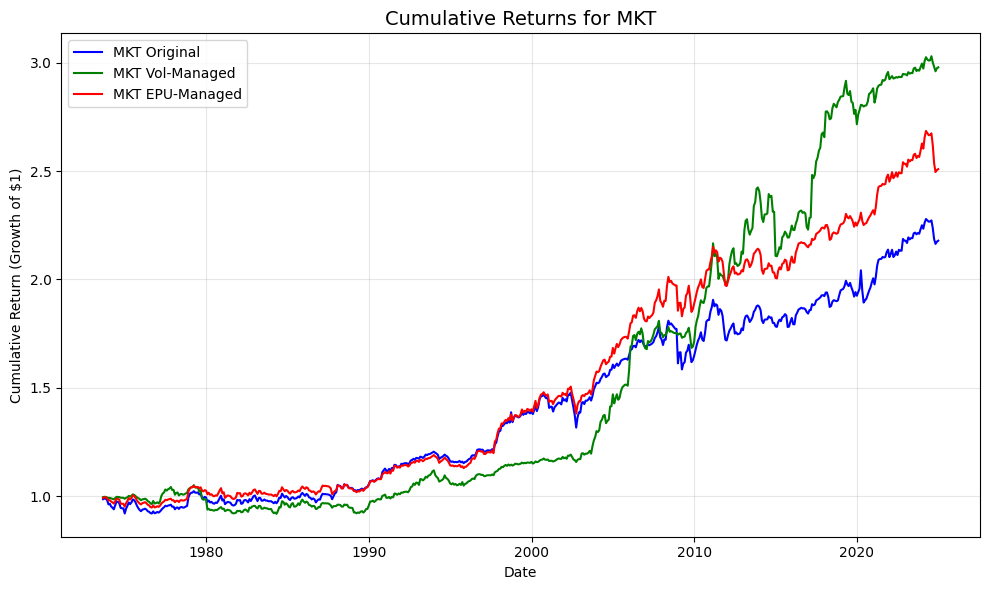

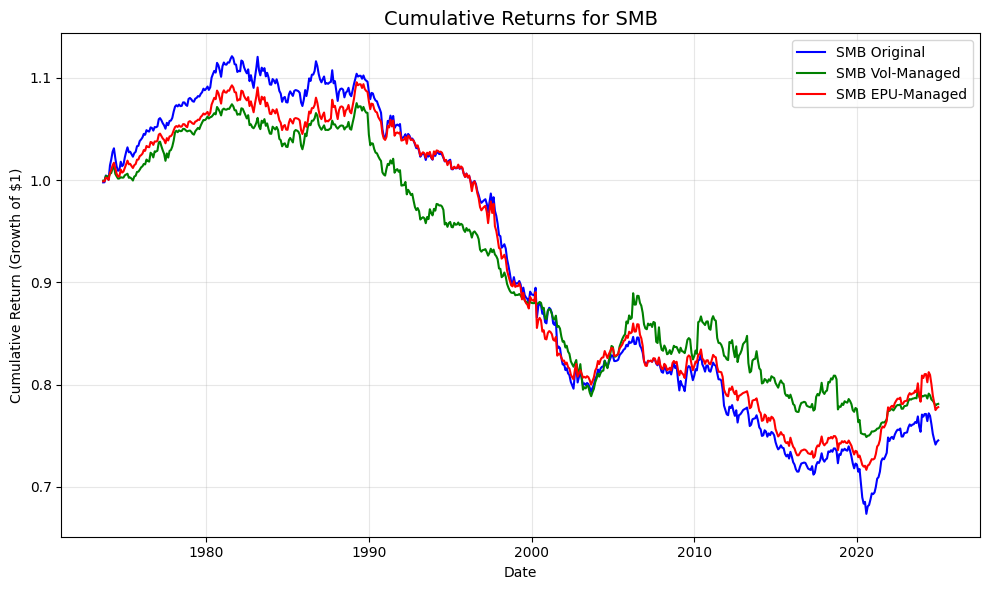

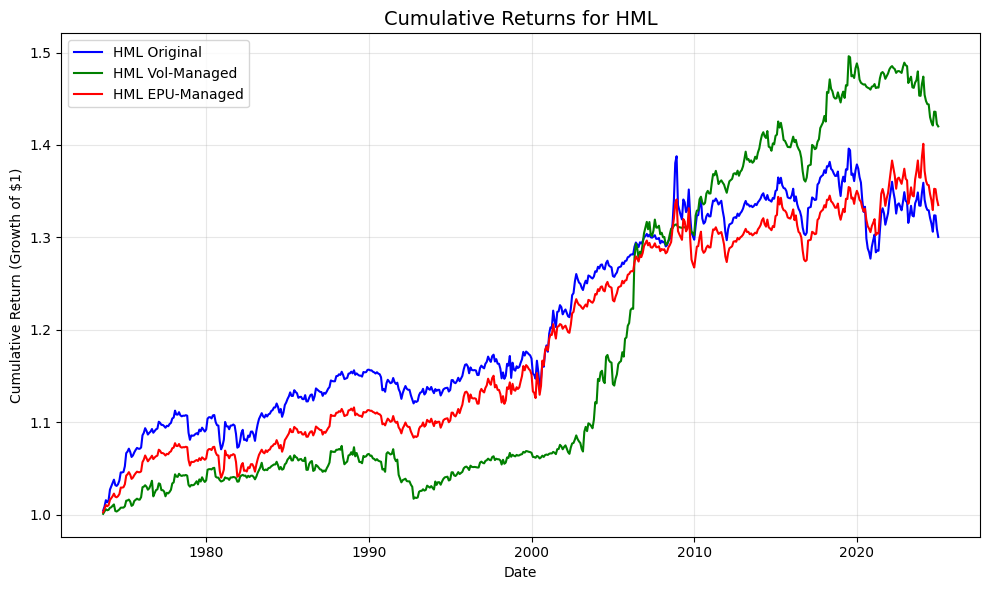

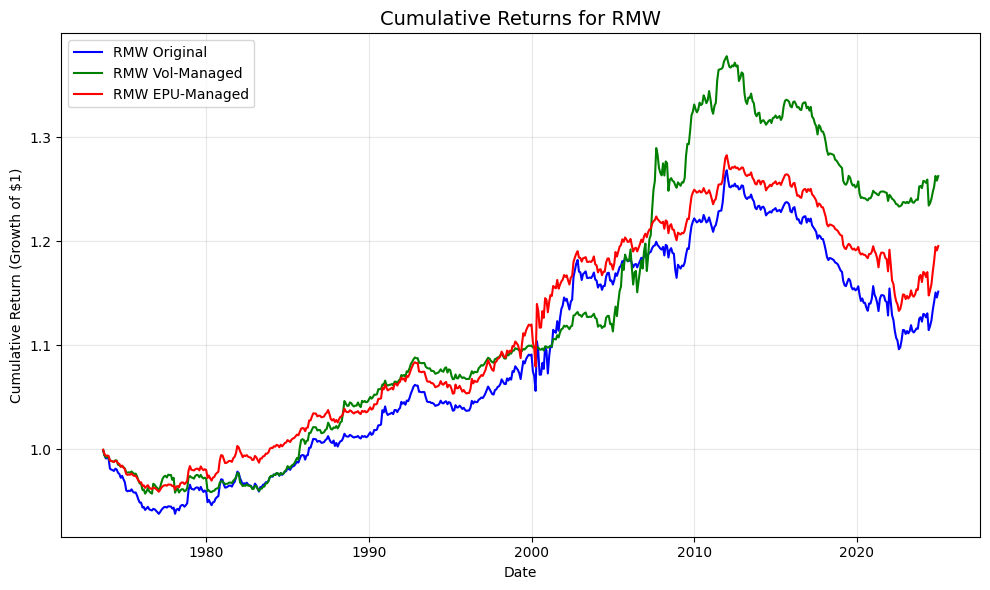

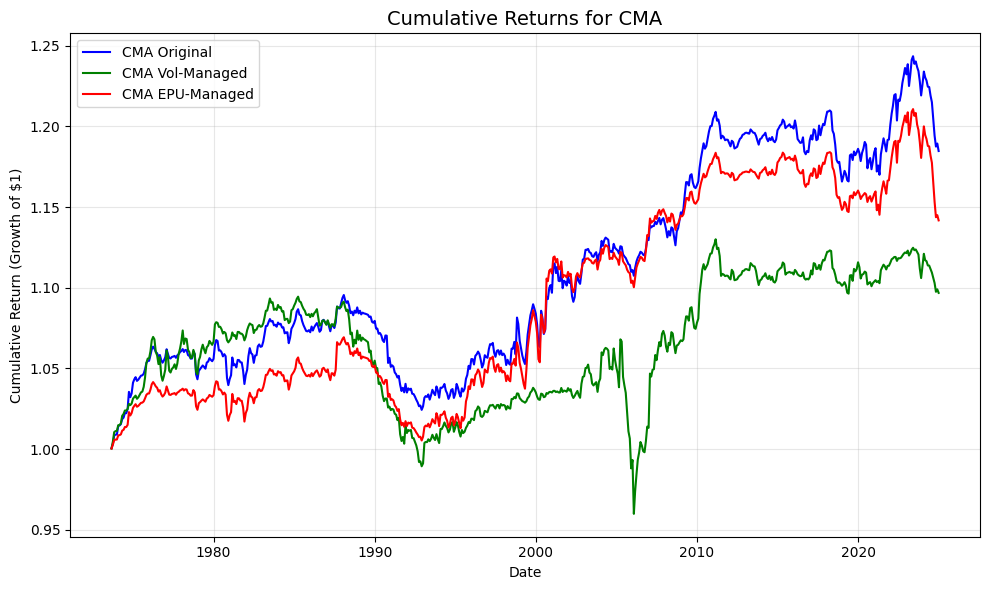

In [25]:
import matplotlib.pyplot as plt

# Function to compute cumulative returns
def cumret(returns):
    return (1 + returns).cumprod()

# Compute cumulative returns
cum_orig = cumret(factor_ret_m)
cum_vol  = cumret(factor_ret_vol_managed_m)
cum_epu  = cumret(factor_ret_epu_managed_m)

# Plot each factor separately
for factor in factor_ret_m.columns:
    plt.figure(figsize=(10,6))
    
    plt.plot(cum_orig.index, cum_orig[factor], label=f"{factor} Original", color="blue")
    plt.plot(cum_vol.index, cum_vol[factor], label=f"{factor} Vol-Managed", color="green")
    plt.plot(cum_epu.index, cum_epu[factor], label=f"{factor} EPU-Managed", color="red")
    
    plt.title(f"Cumulative Returns for {factor}", fontsize=14)
    plt.xlabel("Date")
    plt.ylabel("Cumulative Return (Growth of $1)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
